# Analysis of New York Motor Vehicle Collisions
### UCDPA Project, Hauke Laing

## Setup

In [1]:
# import required libraries
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Collection

### helper functions

In [2]:
def read_api_chunk(api, limit=1000, offset=0):
    """read a single chunk from the api"""
    return pd.read_json(f"{api}?${limit=}&${offset=}")


def read_api(api, total_size, chunk_size=1000):
    """read given number of lines from api, applying the chunk_size along the way"""
    # use https://docs.python.org/3/reference/expressions.html#yield-expressions
    chunk_generator = (
        # define chunks; the last chunk might be smaller than chunk_size
        read_api_chunk(api, limit=min(chunk_size, total_size - x), offset=x)
        for x in range(0, total_size, chunk_size)
    )
    # in the generator expressions, the chunks are not yet read and stored in memory
    # the outer paranthesis are synctactilly required for generator expressions; they
    # are not included simply in order to permit the multiline definition

    # pd.concat can handle generator expressions. According to the api reference, the objs argument
    # accepts a sequence of DataFrame objects. This indicates that any iterable that yields DataFrame
    # objects will be accepted, which is what chunk_generator provides.
    return pd.concat(chunk_generator)

def read_api_2(api, size, n_chunks):
    """read given number of lines from api by splitting the request into n_chunks chunks"""
    grid = np.unique(np.linspace(0, size, num=n_chunks).astype('int'))
    steps = np.diff(grid)
    chunk_generator = (
        read_api_chunk(api, limit=steps[i], offset=grid[i])
        for i in range(len(steps))
    )
    return pd.concat(chunk_generator)

### inputs

In [4]:
# set input parameters
api = "https://data.cityofnewyork.us/resource/h9gi-nx95.json"
n = 600e3
n_chunks = 6
seed = 8

### read data

In [5]:
# read data
# data_raw = read_api_chunk(api, limit=int(n))
# data_raw = read_api(api, total_size=int(100e3), chunk_size=int(25e3))
data_raw = read_api_2(api, size=n, n_chunks=n_chunks)

In [6]:
data_raw.shape

(600000, 29)

## Data Preparation 

### Cleaning

In [7]:
# initial cleaning of data
data_raw_2 = data_raw.rename(
    columns={
        "vehicle_type_code1": "vehicle_type_code_1",
        "vehicle_type_code2": "vehicle_type_code_2",
    }
)
data_raw_2 = data_raw_2.reindex(sorted(data_raw_2.columns), axis=1)
text_cols = [col for col in data_raw_2 if re.search("(street|contributing_factor)", col)]
data_raw_2[text_cols] = data_raw_2[text_cols].astype("string")
data_raw_2.shape

(600000, 29)

In [8]:
# set index
data_raw_2.set_index(keys="collision_id", drop=False, inplace=True)

# remove duplicate collision ids
# ensure the first one is being kept
duplicate_collision_ids = data_raw_2.index.duplicated(keep='first')
data_raw_2 = data_raw_2[~duplicate_collision_ids]
print(f"{sum(duplicate_collision_ids)} duplicate collision ids have been removed.")

0 duplicate collision ids have been removed.


In [9]:
data_raw_2.dtypes

borough                                  object
collision_id                              int64
contributing_factor_vehicle_1    string[python]
contributing_factor_vehicle_2    string[python]
contributing_factor_vehicle_3    string[python]
contributing_factor_vehicle_4    string[python]
contributing_factor_vehicle_5    string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured               float64
number_of_persons_killed                

In [10]:
# plausibility check
invalid_number_of_injured = (
    data_raw_2[
        [
            "number_of_pedestrians_injured",
            "number_of_cyclist_injured",
            "number_of_motorist_injured",
        ]
    ].sum(axis=1)
    > data_raw_2["number_of_persons_injured"]
)
sum(invalid_number_of_injured)

8

In [11]:
data_raw_2 = data_raw_2[~data_raw_2["number_of_persons_injured"].isna()]

### Explore

In [12]:
# explore dataset
occ = data_raw_2["number_of_persons_injured"].value_counts()
print(occ)

number_of_persons_injured
0.0     437848
1.0     125882
2.0      24051
3.0       7677
4.0       2798
5.0       1013
6.0        388
7.0        178
8.0         72
9.0         31
10.0        22
11.0         9
12.0         8
15.0         5
13.0         4
17.0         3
14.0         3
18.0         2
20.0         2
40.0         1
16.0         1
Name: count, dtype: int64


In [13]:
print(occ / sum(occ))

number_of_persons_injured
0.0     0.729749
1.0     0.209804
2.0     0.040085
3.0     0.012795
4.0     0.004663
5.0     0.001688
6.0     0.000647
7.0     0.000297
8.0     0.000120
9.0     0.000052
10.0    0.000037
11.0    0.000015
12.0    0.000013
15.0    0.000008
13.0    0.000007
17.0    0.000005
14.0    0.000005
18.0    0.000003
20.0    0.000003
40.0    0.000002
16.0    0.000002
Name: count, dtype: float64


In [15]:
print(f"In about {(100 * (1 - occ/sum(occ)))[0]:.1f} out of 100 collisions at least one person is injured.")

In about 27.0 out of 100 collisions at least one person is injured.


### Feature Engineering

In [17]:
# the dataset has 5 columns to cover up to 5 vehicles involved in a collision
# format data to cover 5 vehicles in one column
data_long = pd.wide_to_long(
    data_raw_2,
    stubnames=["vehicle_type_code_", "contributing_factor_vehicle_"],
    i="collision_id",
    j="vehicle_no",
)
data_long.rename(
    columns={
        "vehicle_type_code_": "vehicle_type_code",
        "contributing_factor_vehicle_": "contributing_factor_vehicle",
    },
    inplace=True,
)
data_long = data_long.reindex(sorted(data_long.columns), axis=1)


# keep rows for vehicle no. > 1 only if relevant information pertaining to the vehicle is present; the row is redundant otherwise
_cnd1 = (
    data_long[["vehicle_type_code", "contributing_factor_vehicle"]]
    .notnull()
    .any(axis=1)
)
_cnd2 = data_long.index.get_level_values(level=1) == 1
_cnd = _cnd1 | _cnd2
data_long = data_long.loc[_cnd, :]
# export long data
# data_long.to_csv("data_long.csv")
data_long.dtypes

borough                                  object
contributing_factor_vehicle      string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured               float64
number_of_persons_killed                float64
off_street_name                  string[python]
on_street_name                   string[python]
vehicle_type_code                        object
zip_code                                float64
dtype: object

In [18]:
# explore the column 'contributing_factor_vehicle'
data_long["contributing_factor_vehicle"].value_counts()

contributing_factor_vehicle
Unspecified                                          612533
Driver Inattention/Distraction                       183579
Following Too Closely                                 56599
Failure to Yield Right-of-Way                         45715
Passing or Lane Usage Improper                        31199
Passing Too Closely                                   27173
Other Vehicular                                       25645
Backing Unsafely                                      25456
Unsafe Lane Changing                                  18867
Unsafe Speed                                          16167
Traffic Control Disregarded                           14737
Turning Improperly                                    14426
Driver Inexperience                                   11619
Reaction to Uninvolved Vehicle                        10667
Alcohol Involvement                                    7953
View Obstructed/Limited                                6252
Pavement Sli

In [19]:
# The column 'contributing_factor_vehicle' contains a text comment. To prepare the column 
# for machine learning algorithms, we want to categorize it and later create dummies

# First, establish a code representing a contributing factor and a corresponding mapping

confac = (
    data_long["contributing_factor_vehicle"]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
    .to_frame(name="contributing_factor")
)

def get_first_chars(input):
    """retrieve first character of each word in a string of words"""
    return "".join(item[0].upper() for item in re.findall("\w+", input))

# create initial code
confac["cf"] = confac["contributing_factor"].apply(get_first_chars)

# if code is not unique, add counting index
confac["n"] = confac.groupby(["cf"]).cumcount()
_k = confac["n"] > 0
confac.loc[_k, "cf"] = confac.loc[_k, "cf"] + confac.loc[_k, "n"].astype("string")
confac.set_index("contributing_factor", inplace=True)

# export mapping for reference
confac.to_csv("output/confac.csv")

confac_cols = "cf." + confac["cf"]
mapping_cf = pd.Series(confac["cf"]).to_dict()

In [20]:
# determine dummies grouped by collision_id
data_long["cf"] = data_long["contributing_factor_vehicle"].replace(mapping_cf)
# dummies_cf_long = pd.get_dummies(data_long, columns=["cf"], prefix_sep=".")
# dummies_cf = dummies_cf_long[confac_cols].groupby(level=0).max()
# dummies_cf["n_vehicles"] = dummies_cf.sum(axis=1) # store number of vehicles involved
# dummies_cf.head()
data_long["cf"].value_counts()

cf
U         612533
DID       183579
FTC        56599
FTYROW     45715
POLUI      31199
PTC        27173
OV         25645
BU         25456
ULC        18867
US         16167
TCD        14737
TI         14426
DI         11619
RTUV       10667
AI          7953
VOL         6252
PS          6216
PBOPEC      5370
ADRR        4030
OV1         3834
BD          2412
FA          2125
PD          1939
OD          1462
OCD         1457
SF          1141
G           1117
TFI          922
FTKR         865
LC           840
I            834
PD1          762
FD           683
AA           592
DRV          578
DI1          461
LMII         407
TCDINW       372
AD           371
CPHH         264
PD2          218
TW           108
OLD           88
THD           84
OED           77
VV            71
HD            70
UOBND         69
PM            66
EOD           64
CPHF          33
SDI           29
T             22
LUH           19
WI            12
Name: count, dtype: Int64

In [21]:
# similar to the column 'contributing factor' is the column 'vehicle type'
# we want to prepare it as categorical data

# vehicle_type_codes = data_long["vehicle_type_code"].astype("string").dropna()

# align formatting of text
data_long["vehicle_type"] = (
    data_long["vehicle_type_code"]
    .str.replace(pat=r"\W+", repl="_", regex=True)
    .str.lower()
)

print(data_long["vehicle_type"].nunique())
print(data_long["vehicle_type"].value_counts())

1126
vehicle_type
sedan                                  495758
station_wagon_sport_utility_vehicle    394551
taxi                                    39141
pick_up_truck                           30926
box_truck                               25253
                                        ...  
dumpt                                       1
light                                       1
army                                        1
fdny_lader                                  1
van_ford                                    1
Name: count, Length: 1126, dtype: int64


In [22]:
# reduce to top 50 most frequent types of cars. last category is set to "other"
top = 50
vehicle_top_cats = data_long["vehicle_type"].value_counts().head(top - 1).index
data_long["vt"] = data_long["vehicle_type"]

data_long.loc[
    ~data_long["vehicle_type"].isin(vehicle_top_cats)
    & ~data_long["vehicle_type"].isna(),
    ["vt"],
] = "other"

data_long["vt"] = data_long["vt"].astype("category")
data_long["vt"].value_counts()

vt
sedan                                  495758
station_wagon_sport_utility_vehicle    394551
taxi                                    39141
pick_up_truck                           30926
box_truck                               25253
bike                                    22880
bus                                     18048
tractor_truck_diesel                     9481
van                                      7450
motorcycle                               7346
e_bike                                   5415
other                                    5177
ambulance                                4143
dump                                     3727
e_scooter                                3566
convertible                              2836
flat_bed                                 2456
garbage_or_refuse                        2130
pk                                       2033
moped                                    1956
carry_all                                1586
tractor_truck_gasoline         

In [23]:
# now we are ready to create dummies from the 'contributing factor' and
# 'vehicle type' columns. The processed versions of these columns have been 
# stored as 'cf' and 'vt'

dummies_long = pd.get_dummies(
    data_long, prefix=["vt", "cf"], columns=["vt", "cf"], prefix_sep="."
)
dummies = dummies_long.filter(regex=r"^(vt|cf)\.").groupby(level=0).max()
dummies["n_vehicles"] = dummies.filter(regex=r"^cf\.").sum(axis=1) # store number of vehicles involved

# after using contributing factor to deduce the number of involved vehicles
# we drop the dummie for the value 'Unspecified', as it can now be regarded as NaN
dummies = dummies.drop(columns=["cf." + mapping_cf["Unspecified"]])

dummies.head()

,vt.3_door,vt.4_dr_sedan,vt.ambul,vt.ambulance,vt.armored_truck,vt.beverage_truck,vt.bike,vt.box_truck,vt.bus,vt.carry_all,...,cf.THD,cf.TI,cf.TW,cf.ULC,cf.UOBND,cf.US,cf.VOL,cf.VV,cf.WI,n_vehicles
collision_id,,,,,,,,,,,,,,,,,,,,,
3456194,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3460534,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3511951,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,2
3528065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3618395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [25]:
# after creating dummies, it is useful to create a copy of
# the data with the source columns for the dummies removed
data_raw_4 = data_raw_2.drop(
    columns=[
        "vehicle_type_code_1",
        "vehicle_type_code_2",
        "vehicle_type_code_3",
        "vehicle_type_code_4",
        "vehicle_type_code_5",
        "contributing_factor_vehicle_1",
        "contributing_factor_vehicle_2",
        "contributing_factor_vehicle_3",
        "contributing_factor_vehicle_4",
        "contributing_factor_vehicle_5"
    ]
)



In [26]:
# as the collision id serves as index for both dataframes, they can easily be joined. 
collisions = data_raw_4.join(dummies)
# collisions.to_csv("output/collisions.csv")

## Algorithm Setup

In [27]:
# import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
# import model selection utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [28]:
# split data
X = collisions.filter(regex=r"^(vt|cf)\.", axis=1)
y = collisions["number_of_persons_injured"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4)

### Estimator Comparison

#### Initial Comparison

In [29]:
# import models
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier

In [137]:
# determine cross-validation score for a list of models

models_initial = {
    "ridge": RidgeClassifier(),
    "tree": DecisionTreeClassifier(random_state=seed),
    "tree2": DecisionTreeClassifier(random_state=seed, min_samples_leaf=10),
    'bernoulli': BernoulliNB(binarize=None)
}

kf = KFold(random_state=seed, shuffle=True)
cross_scores_initial = [cross_val_score(clf, X_train, y_train, cv=kf) for clf in models_initial.values()]

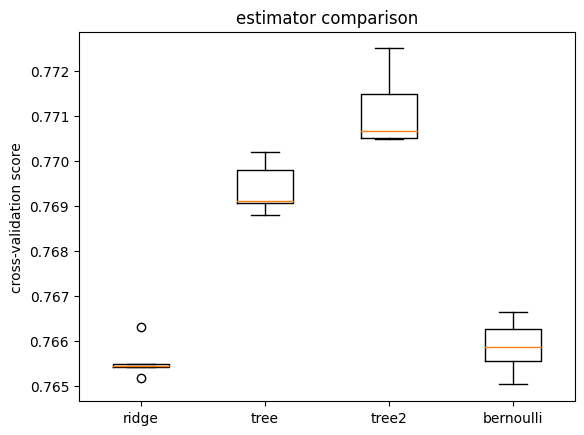

In [138]:
plt.boxplot(cross_scores_initial, labels=models_initial.keys())
plt.title("estimator comparison")
plt.ylabel("cross-validation score")
plt.show()

In [92]:
# The decision tree shows the best performance. 
# However, trees have a high risk of overfitting. 
# Therefore, we will also compare the scores for the prediction on the test set.

for clf in models_initial.values():
    clf.fit(X_train, y_train)

scores_initial = [clf.score(X_test, y_test) for clf in models_initial.values()]
scores_initial_train = [clf.score(X_train, y_train) for clf in models_initial.values()]
    

In [94]:
# build dataframe to compare cross-validation and test scores
df_scores_initial = pd.DataFrame([scores_initial, scores_initial_train, np_cross_scores_initial.mean(axis=1)]).transpose()
df_scores_initial.columns = ["test_score", "training_score", "cv_mean_score"]
df_scores_initial.index = models_initial.keys()
df_scores_initial["cv_vs_test"] = (df_scores_initial["cv_mean_score"] - df_scores_initial["test_score"]) * 100
df_scores_initial["train_vs_test"] = (df_scores_initial["training_score"] - df_scores_initial["test_score"]) * 100
df_scores_initial.to_csv("output/scores_initial.csv")
df_scores_initial


,test_score,training_score,cv_mean_score,cv_vs_test,train_vs_test
ridge,0.764913,0.765623,0.765566,0.065229,0.071007
tree,0.769200,0.777770,0.769412,0.021231,0.857012
bernoulli,0.765107,0.765843,0.765877,0.077007,0.073674


#### Tree-based Models

In [83]:
# import tree-based models from ensemble module
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [101]:
# determine cross-validation score for a list of tree-based models
models_tree = {
    "tree": DecisionTreeClassifier(max_depth=7, random_state=seed),
    'forest': RandomForestClassifier(max_depth=7, random_state=seed),
    'bagging': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=7), random_state=seed)
}
scores_tree = [cross_val_score(clf, X_train, y_train, cv=kf) for clf in models_tree.values()]

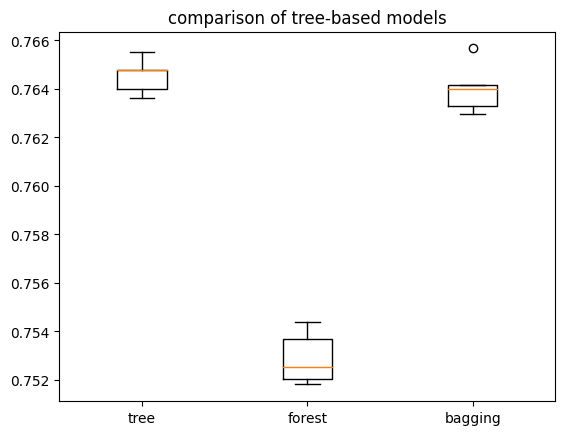

In [103]:
# plot results
plt.boxplot(scores_tree, labels=models_tree.keys())
plt.title("comparison of tree-based models")
plt.show()
# a decision tree is still best, but not bagging is almost as good
# we perform a direct prediction on the isolated test set to see if the decision tree is still ahead

In [97]:
# perform a prediction with a decision tree on the actual test set
tree = DecisionTreeClassifier(random_state=seed)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
acc_score_tree = accuracy_score(y_test, y_pred_tree)

In [98]:
# perform the same prediction with a bagging classifier
bag = BaggingClassifier(random_state=seed)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
acc_score_bag = accuracy_score(y_test, y_pred_bag)

In [104]:
# compare the outcome
print(f"The decision tree achieves a score of {acc_score_tree} on the test set")
print(f"The bagging classifier achieves a score of {acc_score_bag} on the test set")
# a decision tree is still better!

The decision tree achieves a score of 0.7692 on the test set
The bagging classifier achieves a score of 0.76906 on the test set


### Focus on Decision Tree

In [105]:
# import utility to display confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

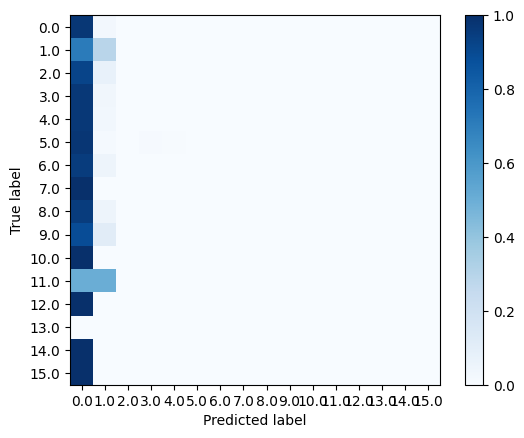

In [106]:
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, normalize='true', include_values=False, cmap=plt.cm.Blues)

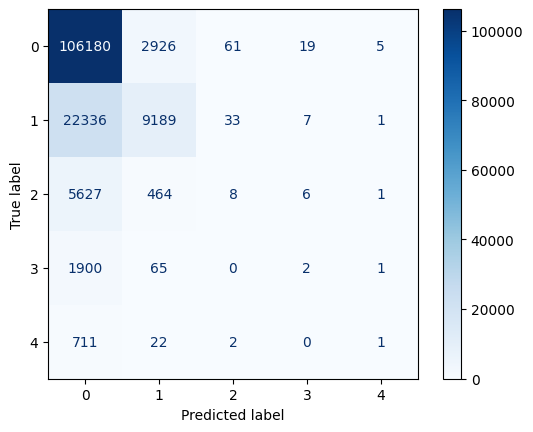

In [119]:
# focus on smaller set of classes
cm = confusion_matrix(y_test, y_pred_tree)
cm_small = cm[0:5, 0:5]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_small)
disp.plot(cmap=plt.cm.Blues)

### Boosting

In [108]:
# initialise an AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
dt = DecisionTreeClassifier(max_depth=2, random_state=seed)
ada = AdaBoostClassifier(estimator=dt, n_estimators=100)

In [109]:
# perform cross-validation
ada_cv = cross_val_score(ada, X_train, y_train, cv=kf)

In [111]:
# append results to previous results for tree-based models
models_boost = models_tree
scores_boost = scores_tree

models_tree['ada'] = ada
scores_boost.append(ada_cv)


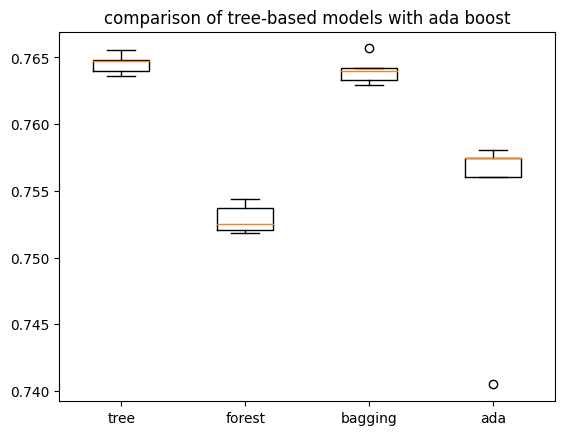

In [113]:
# plot results
plt.boxplot(scores_boost, labels=models_boost.keys())
plt.title("comparison of tree-based models with ada boost")
plt.show()

### Hyper-Parameter Boosting

#### Decision Tree Classifier

In [124]:
# we first have a closer look at the Ridge Classifier
from sklearn.model_selection import GridSearchCV

In [169]:
# initialise grid search
tree_params = {
        # "max_depth": np.arange(5, 10),
        "max_depth": [2, 3, 4],
        "min_samples_leaf": np.arange(1, 51, 5)
        }
tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=seed), tree_params, cv=kf)

# execute
tree_cv.fit(X_train, y_train)
tree_cv_res = pd.DataFrame.from_dict(tree_cv.cv_results_)

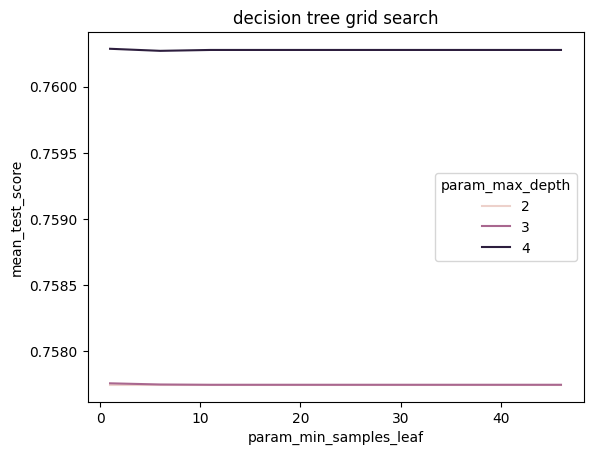

In [170]:
# plot results
ax = sns.lineplot(data=tree_cv_res, x="param_min_samples_leaf", y = "mean_test_score", hue = "param_max_depth")
ax.set(
    title="decision tree grid search"
)
plt.show()

In [166]:
tree_cv.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=36, random_state=8)